In [1]:
# This project aims at classifying house interior as modern (M) or old (O).
# The dataset comes from Kaggle "House  Rooms Image Dataset" and contains
# 5250 images from 5 different rooms (Bathroom, Bedroom, Dinning, Kitchen,
# and Livingroom). The dataset is not so well balanced as some rooms
# contains more images than others, e.g: bathroom contains 606 images
# vs 1248 for bedroom.
# Also note that the dataset is unlabelled, however, a hand labelled file of
# about 450 images is provided by
# this (https://github.com/V-Sher/house-interior-prediction) github repo.
# Note  that these label are only for the first 450 images in bedrooms.
# This is quite small but let see what we can achieve. 

# Excited? Let's go !

# 1. Import libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shutil


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2. EDA : Exploratory Data Analysis

## 2.1. Process labels

In [3]:
# Read labels from labels.txt file
with open("labels.txt", 'r') as f:
    manual_labels = f.read()
    
# Extract individual labels into a list
labels = [i for i in manual_labels]
print("Number of labelled images : ",len(labels))

# check the balance
from collections import Counter

print(Counter(labels).keys())
print(Counter(labels).values())

Number of labelled images :  451
dict_keys(['O', 'M'])
dict_values([271, 180])


In [4]:
# From previous cell output, we can see that we only have 451 labelled images.
# This means our trainning set is 451 images.
# We can also see that there is more old (O) houses compared to modern ones
# in the  dataset (although not by a very large margin). 
# Hence, it makes sense to ditch accuracy and pick a metric that is more 
# suitable to deal with imbalanced classes, namely AUC (Area Under ROC curve)
# or MCC (Matthews correlation coefficient).

## 2.2. Train Test Validation Splits

In [5]:
# Remember that we only the labels for the first 451 images of bedrooms.
# Before splitting the data we need to sort filenames as by default
# os.listdir() returns files in some random order.

In [6]:
dataset_dir = 'House_Room_Dataset/Bedroom'

# sorting files in the order they appear
files = os.listdir(dataset_dir)
files.sort(key=lambda f: int(f.split('_')[1].split('.')[0]))

# check the result by printing a subset
files[:10]

['bed_1.jpg',
 'bed_2.jpg',
 'bed_3.jpg',
 'bed_4.jpg',
 'bed_8.jpg',
 'bed_9.jpg',
 'bed_10.jpg',
 'bed_11.jpg',
 'bed_12.jpg',
 'bed_14.jpg']

In [7]:
# Now that the files are in the right order, let split them
# into train_set (60%), val_set (20%) and test_set (20%).

# split files into train and test sets
X_train, X_test, y_train, y_test = train_test_split(files[:len(labels)],
                                                   labels,
                                                   stratify=labels,
                                                   test_size=0.2,
                                                   random_state=0)

# further split the train set into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                   y_train,
                                                   stratify=y_train,
                                                   test_size=0.25,
                                                   random_state=0)

# check the size of train_set, val_set and test_set
print(f"train_set : images number = {len(X_train)}", end=" ") 
print(f"associated labels number = {len(y_train)}",  end=" ")
print(f"ratio = {round((len(X_train)/len(labels))*100.0)}%")

print(f"val_set : images number = {len(X_val)}", end=" ") 
print(f"associated labels number = {len(y_val)}",  end=" ")
print(f"ratio = {round((len(X_val)/len(labels))*100.0)}%")

print(f"test_set : images number = {len(X_test)}", end=" ") 
print(f"associated labels number = {len(y_test)}",  end=" ")
print(f"ratio = {round((len(X_test)/len(labels))*100.0)}%")

train_set : images number = 270 associated labels number = 270 ratio = 60%
val_set : images number = 90 associated labels number = 90 ratio = 20%
test_set : images number = 91 associated labels number = 91 ratio = 20%


In [22]:
# Let organize the splitted datasets into directories
# This will allow us to use the ".flow_from_directory()"
# function from Keras library.

BASE_PATH = "dataset"
TRAIN = "training"
VAL = "evaluation"
TEST = "testing"

# Building the dataset properly - 
splits = [(X_train, y_train), (X_test, y_test), (X_val, y_val)]
dirnames = [TRAIN, TEST, VAL]

for i, (data, label) in enumerate(splits):
    outside_dir = dirnames[i]

    for j in tqdm(range(0, len(label)), desc = "Iterating over images in sub folder"):
        dirname = label[j]
        
        # construct the path to the sub-directory
        dirPath = os.path.join(BASE_PATH, outside_dir, dirname)
        
        # if the output directory does not exist, create it
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)
            
            
        # copy the img to this new directory
        src_img = os.path.join(dataset_dir, data[j])
        shutil.copy(src_img, dirPath)


Iterating over images in sub folder: 100%|████████████████████████████████████████████| 90/90 [00:00<00:00, 496.64it/s]


## 2.2. Image preprocessing

In [9]:
# As the training set is quite small, I'll use "ImageDataGenerator"
# to augment the training set. One can think about using this 
# data augmentation process also on the validation set but
# it should not be the case as to correctely build a model,
# the validation and test sets should come from the same
# distibution. In other word, the validation set should be a 
# subset of what we expect to get in testing. So, if we augment
# validation data, we should apply the same transformation to
# test data.

# For the first iteration no data augmentation should be done.
# I'll comeback here if the results suggest I should.

# As you may already know, data that goes into neural networks 
# should usually be normalized in some way to make it more amenable 
# to processing by the network. (It is uncommon to feed raw pixels 
# into a convnet.) In our case, we will preprocess our images by 
# normalizing the pixel values to be in the [0, 1] range 
# (originally all values are in the [0, 255] range).

trainAug = ImageDataGenerator(rescale=1.0/255.)
valAug = ImageDataGenerator(rescale=1.0/255.)
testAug = ImageDataGenerator(rescale=1.0/255.)

trainPath = os.path.join(BASE_PATH, TRAIN)
valPath = os.path.join(BASE_PATH, VAL)
testPath = os.path.join(BASE_PATH, TEST)

target_size = (224, 224)
batch_size = 32

trainGen = trainAug.flow_from_directory(trainPath,
                                        target_size=target_size,
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=True)

valGen = valAug.flow_from_directory(valPath,
                                    target_size=target_size,
                                    batch_size=batch_size,
                                    class_mode='binary',
                                    shuffle=True)

testGen = testAug.flow_from_directory(testPath,
                                      target_size=target_size,
                                      batch_size=batch_size,
                                      class_mode = 'binary',
                                      shuffle=False)

Found 270 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 91 images belonging to 2 classes.


# 3. Build a first Model from Scratch and analyse performance

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model

input_shape = (224, 224, 3)

model = Sequential([
    Conv2D(filters=16, kernel_size= (3, 3), activation= 'relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=32, kernel_size= (3, 3), activation= 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=64, kernel_size= (3, 3), activation= 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=1, activation="sigmoid")    
])

# See the summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [11]:
from tensorflow.keras.optimizers import RMSprop, Adam

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[tf.keras.metrics.AUC()])


# Let's train our dataset for 30 epochs
epochs = 30
totalTrain = len(X_train)
totalVal = len(X_val)

history = model.fit(trainGen, 
          epochs=epochs, 
          steps_per_epoch=totalTrain // batch_size, 
          validation_data=valGen,
          validation_steps=totalVal // batch_size,
          verbose=2)

Epoch 1/30
8/8 - 9s - loss: 2.8175 - auc: 0.5199 - val_loss: 0.6902 - val_auc: 0.4264 - 9s/epoch - 1s/step
Epoch 2/30
8/8 - 9s - loss: 0.6857 - auc: 0.4696 - val_loss: 0.6846 - val_auc: 0.4810 - 9s/epoch - 1s/step
Epoch 3/30
8/8 - 7s - loss: 0.6829 - auc: 0.4977 - val_loss: 0.6772 - val_auc: 0.4772 - 7s/epoch - 823ms/step
Epoch 4/30
8/8 - 7s - loss: 0.6694 - auc: 0.6205 - val_loss: 0.6574 - val_auc: 0.5048 - 7s/epoch - 829ms/step
Epoch 5/30
8/8 - 7s - loss: 0.6530 - auc: 0.7350 - val_loss: 0.7079 - val_auc: 0.5293 - 7s/epoch - 826ms/step
Epoch 6/30
8/8 - 7s - loss: 0.6639 - auc: 0.5745 - val_loss: 0.6399 - val_auc: 0.6661 - 7s/epoch - 922ms/step
Epoch 7/30
8/8 - 7s - loss: 0.6370 - auc: 0.7303 - val_loss: 0.6642 - val_auc: 0.6087 - 7s/epoch - 926ms/step
Epoch 8/30
8/8 - 7s - loss: 0.6140 - auc: 0.6932 - val_loss: 0.6774 - val_auc: 0.6292 - 7s/epoch - 891ms/step
Epoch 9/30
8/8 - 7s - loss: 0.6216 - auc: 0.7102 - val_loss: 0.6530 - val_auc: 0.5854 - 7s/epoch - 908ms/step
Epoch 10/30
8/8 

No. of test images 91
{'M': 0, 'O': 1}


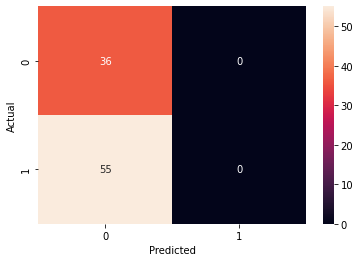

In [12]:
# model testing
totalTest = len(X_test)
testGen.reset()

predIdxs = model.predict(x=testGen, steps=(totalTest // batch_size) + 1)
predIdxs = np.argmax(predIdxs, axis = 1)

print("No. of test images", len(predIdxs))
print(testGen.class_indices)

cm = confusion_matrix(testGen.classes, predIdxs)
heatmap = sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [13]:
predIdxs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

# 4. Evaluating model performance

## 4.1. Visualizing Intermediate Representations

dataset\training\O\bed_397.jpg


C:\Users\silve\AppData\Local\Temp/ipykernel_18484/2244611708.py:72: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


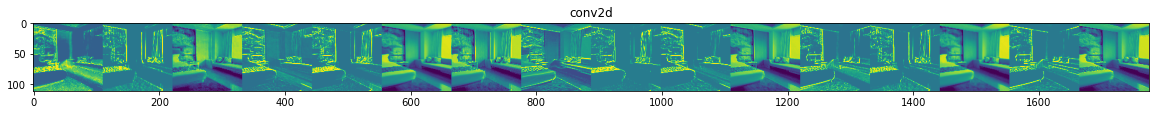

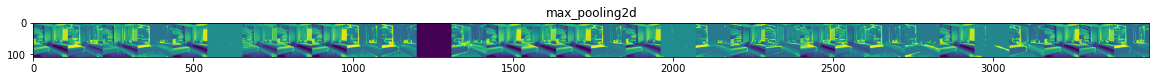

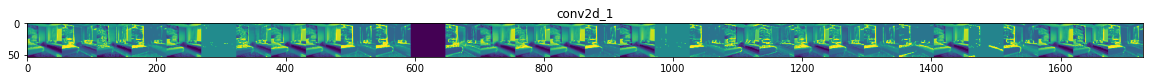

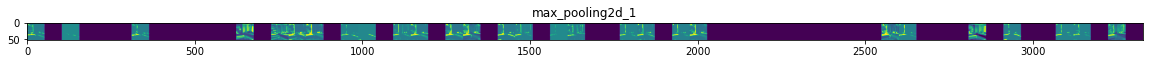

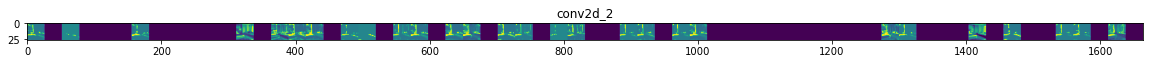

In [14]:
# To get a feel for what kind of features our convnet has learned, 
# one fun thing to do is to visualize how an input gets transformed 
# as it goes through the convnet.

# Let's pick a random old or modern image from the training set, 
# and then generate a figure where each row is the output of a layer, 
# and each image in the row is a specific filter in that output feature map. 
# Rerun this cell to generate intermediate representations for a variety 
# of training images.

import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

train_old_dir = os.path.join(trainPath, 'O')
train_mod_dir = os.path.join(trainPath, 'M')

train_old_fnames = os.listdir( train_old_dir )
train_mod_fnames = os.listdir( train_mod_dir )

# Let's prepare a random input image of a modern or old from the training set.
mod_img_files = [os.path.join(train_mod_dir, f) for f in train_mod_fnames]
old_img_files = [os.path.join(train_old_dir, f) for f in train_old_fnames]

img_path = random.choice(mod_img_files + old_img_files)
print(img_path)
img = load_img(img_path, target_size=(224, 224))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (224, 224, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 224, 224, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

<Figure size 432x288 with 0 Axes>

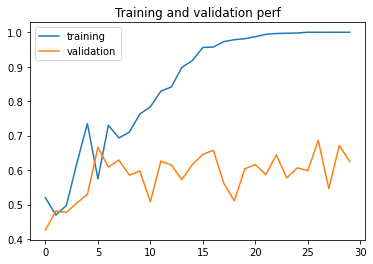

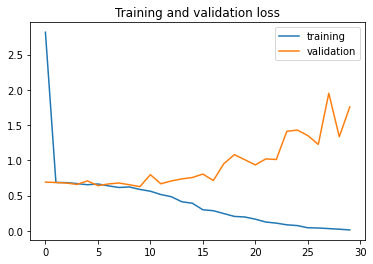

<Figure size 432x288 with 0 Axes>

In [15]:
# Retrieve metric performance and loss

train_perf = history.history["auc"]
val_perf = history.history["val_auc"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(train_perf)) # Get the number of epochs

#--------------------------------------------------------
# Plot training and validation performance per epoch
#--------------------------------------------------------
plt.plot(epochs, train_perf, label='training')
plt.plot(epochs, val_perf, label='validation')
plt.title('Training and validation perf')
plt.legend()
plt.figure()

#--------------------------------------------------------
# Plot training and validation loss per epoch
#--------------------------------------------------------
plt.plot(epochs, train_loss, label='training')
plt.plot(epochs, val_loss, label='validation')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

# II. Data augmentation

In [16]:
# As you can see, we are overfitting like it's getting out of fashion. 
# Our training performance (in blue) gets close to 100% (!) 
# while our validation accuracy (in orange) stalls as 60%. 
# Our training loss reaches its minimum after (let say) 15 epochs.

# Since we have a relatively small number of training examples (270), 
# overfitting should be our number one concern. Overfitting happens 
# when a model exposed to too few examples learns patterns 
# that do not generalize to new data, i.e. when the model starts using
# irrelevant features for making predictions. For instance, if you, 
# as a human, only see three images of people who are lumberjacks, 
# and three images of people who are sailors, and among them the only 
# person wearing a cap is a lumberjack, you might start thinking that 
# wearing a cap is a sign of being a lumberjack as opposed to a sailor. 
# You would then make a pretty lousy lumberjack/sailor classifier.

# Overfitting is the central problem in machine learning: given that 
# we are fitting the parameters of our model to a given dataset, 
# how can we make sure that the representations learned by the model 
# will be applicable to data never seen before? How do we avoid learning 
# things that are specific to the training data?

# As our dataset is quite small, to tackle the overfitting problem we can
# use image augmentation to get generate more data for our training set.
# To do so, let use the ImageDataGenerator.


trainAug = ImageDataGenerator(rescale=1.0/255.,
                              rotation_range=90,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.5,
                              horizontal_flip=True,
                              fill_mode='nearest')

trainGen = trainAug.flow_from_directory(trainPath,
                                        target_size=target_size,
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=True)

valGen.reset()
testGen.reset()

Found 270 images belonging to 2 classes.


In [17]:
# Let retrain our model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[tf.keras.metrics.AUC()])


# Let's train our dataset for 30 epochs
epochs = 30
totalTrain = len(X_train)
totalVal = len(X_val)

history = model.fit(trainGen, 
          epochs=epochs, 
          steps_per_epoch=totalTrain // batch_size, 
          validation_data=valGen,
          validation_steps=totalVal // batch_size,
          verbose=2)

Epoch 1/30
8/8 - 10s - loss: 0.9087 - auc_1: 0.5463 - val_loss: 0.6979 - val_auc_1: 0.5455 - 10s/epoch - 1s/step
Epoch 2/30
8/8 - 11s - loss: 0.6257 - auc_1: 0.6715 - val_loss: 0.6434 - val_auc_1: 0.6431 - 11s/epoch - 1s/step
Epoch 3/30
8/8 - 8s - loss: 0.6247 - auc_1: 0.6623 - val_loss: 0.6677 - val_auc_1: 0.5933 - 8s/epoch - 1s/step
Epoch 4/30
8/8 - 9s - loss: 0.6492 - auc_1: 0.6052 - val_loss: 0.6404 - val_auc_1: 0.6731 - 9s/epoch - 1s/step
Epoch 5/30
8/8 - 9s - loss: 0.6374 - auc_1: 0.6463 - val_loss: 0.6141 - val_auc_1: 0.6933 - 9s/epoch - 1s/step
Epoch 6/30
8/8 - 9s - loss: 0.6308 - auc_1: 0.6582 - val_loss: 0.6303 - val_auc_1: 0.6495 - 9s/epoch - 1s/step
Epoch 7/30
8/8 - 9s - loss: 0.6328 - auc_1: 0.6632 - val_loss: 0.6543 - val_auc_1: 0.6762 - 9s/epoch - 1s/step
Epoch 8/30
8/8 - 9s - loss: 0.6292 - auc_1: 0.6662 - val_loss: 0.6343 - val_auc_1: 0.5963 - 9s/epoch - 1s/step
Epoch 9/30
8/8 - 9s - loss: 0.6184 - auc_1: 0.6883 - val_loss: 0.6623 - val_auc_1: 0.6022 - 9s/epoch - 1s/st

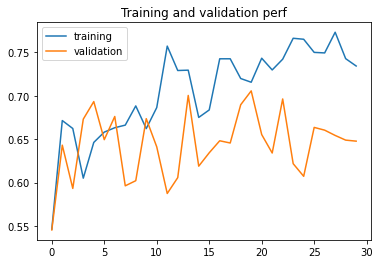

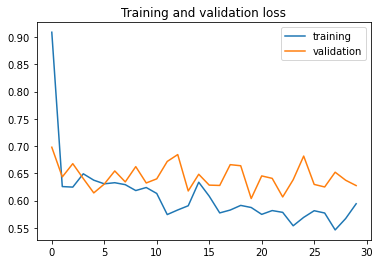

<Figure size 432x288 with 0 Axes>

In [18]:
# Let plot training curve to analyze our model performance

# In order to keep the code clean, let create a module to contain some of 
# our functions in usefull_functions.py to just import them when needed

from usefull_functions import plot_training_curve

plot_training_curve(history=history, training=("auc_1", "loss"), validation=("val_auc_1", "val_loss"))

In [19]:
# Training and validation curves stack with each other. This is a clear
# sign of we've solve the overfitting we had earlier.

# While performance are little lower than earlier, it is also trending
# upward. So perhaps some more epochs will get us close to 100%.

# Let give it a try!

In [20]:
# Let's train our dataset for 30 epochs

# As the same data generators i.e. trainGen,valGen, and testGen, 
# will be used , it is important to reset them so they start with 
# the very first sample in the dataset.

trainGen.reset()
valGen.reset()
testGen.reset()

epochs = 100
totalTrain = len(X_train)
totalVal = len(X_val)

history = model.fit(trainGen, 
          epochs=epochs, 
          steps_per_epoch=totalTrain // batch_size, 
          validation_data=valGen,
          validation_steps=totalVal // batch_size,
          verbose=2)

Epoch 1/100
8/8 - 8s - loss: 0.5769 - auc_1: 0.7485 - val_loss: 0.6662 - val_auc_1: 0.6270 - 8s/epoch - 1s/step
Epoch 2/100
8/8 - 8s - loss: 0.5755 - auc_1: 0.7349 - val_loss: 0.6753 - val_auc_1: 0.6371 - 8s/epoch - 1s/step
Epoch 3/100
8/8 - 8s - loss: 0.5924 - auc_1: 0.7196 - val_loss: 0.6361 - val_auc_1: 0.6204 - 8s/epoch - 1s/step
Epoch 4/100
8/8 - 8s - loss: 0.5971 - auc_1: 0.7237 - val_loss: 0.5694 - val_auc_1: 0.7595 - 8s/epoch - 1s/step
Epoch 5/100
8/8 - 8s - loss: 0.5634 - auc_1: 0.7607 - val_loss: 0.6232 - val_auc_1: 0.6999 - 8s/epoch - 1s/step
Epoch 6/100
8/8 - 9s - loss: 0.5934 - auc_1: 0.7221 - val_loss: 0.6123 - val_auc_1: 0.6642 - 9s/epoch - 1s/step
Epoch 7/100
8/8 - 9s - loss: 0.5702 - auc_1: 0.7445 - val_loss: 0.6881 - val_auc_1: 0.6564 - 9s/epoch - 1s/step
Epoch 8/100
8/8 - 10s - loss: 0.5769 - auc_1: 0.7336 - val_loss: 0.7226 - val_auc_1: 0.5861 - 10s/epoch - 1s/step
Epoch 9/100
8/8 - 14s - loss: 0.5601 - auc_1: 0.7440 - val_loss: 0.6525 - val_auc_1: 0.6716 - 14s/epoc

Epoch 73/100
8/8 - 15s - loss: 0.5004 - auc_1: 0.8175 - val_loss: 0.6893 - val_auc_1: 0.7017 - 15s/epoch - 2s/step
Epoch 74/100
8/8 - 16s - loss: 0.5439 - auc_1: 0.7752 - val_loss: 0.5797 - val_auc_1: 0.7610 - 16s/epoch - 2s/step
Epoch 75/100
8/8 - 11s - loss: 0.5241 - auc_1: 0.7979 - val_loss: 0.6115 - val_auc_1: 0.7036 - 11s/epoch - 1s/step
Epoch 76/100
8/8 - 12s - loss: 0.5809 - auc_1: 0.7298 - val_loss: 0.6067 - val_auc_1: 0.6426 - 12s/epoch - 2s/step
Epoch 77/100
8/8 - 17s - loss: 0.5290 - auc_1: 0.7900 - val_loss: 0.6269 - val_auc_1: 0.6844 - 17s/epoch - 2s/step
Epoch 78/100
8/8 - 18s - loss: 0.5216 - auc_1: 0.7978 - val_loss: 0.7095 - val_auc_1: 0.6361 - 18s/epoch - 2s/step
Epoch 79/100
8/8 - 16s - loss: 0.5259 - auc_1: 0.7947 - val_loss: 0.6593 - val_auc_1: 0.6969 - 16s/epoch - 2s/step
Epoch 80/100
8/8 - 16s - loss: 0.5532 - auc_1: 0.7683 - val_loss: 0.5851 - val_auc_1: 0.7768 - 16s/epoch - 2s/step
Epoch 81/100
8/8 - 18s - loss: 0.5409 - auc_1: 0.7785 - val_loss: 0.7000 - val_a

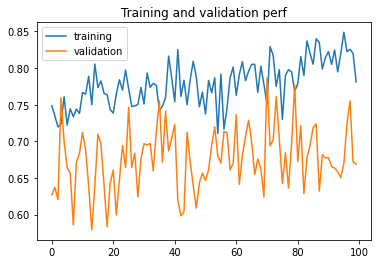

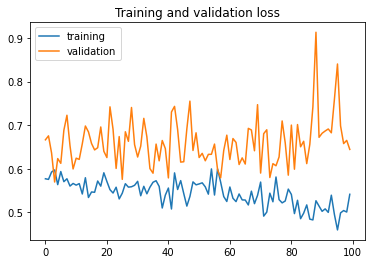

<Figure size 432x288 with 0 Axes>

In [21]:
plot_training_curve(history=history, training=("auc_1", "loss"), validation=("val_auc_1", "val_loss"))

In [23]:
# Training longer did not produce our expectations. 
# While the training performance is climbing, both traning and 
# validation performance are fluctuating like crazy.
# So what we can learn from this is that the image augmentation
# introduces some random elements to the training images but the 
# validation set doesn't have the same randomness then it result 
# fluctuated like this. So remeber that we don't just need 
# a broad set of images for training, we also need them for testing
# or the image augmentation won't help very much.

# We can also see that the model is prone to some overfitting.
# This may be because some nodes over learn.
# Let keep things at they are (image augmentation on training set)
# and add some Dropout in our model to tackle this issue.

model = Sequential([
    Conv2D(filters=16, kernel_size= (3, 3), activation= 'relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(rate=0.2),
    
    Conv2D(filters=32, kernel_size= (3, 3), activation= 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(rate=0.2),
    
    Conv2D(filters=64, kernel_size= (3, 3), activation= 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(rate=0.2),
    
    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(rate=0.2),
    Dense(units=1, activation='sigmoid')    
])
model.summary()


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[tf.keras.metrics.AUC()])

trainGen.reset()
valGen.reset()
testGen.reset()

epochs = 100
totalTrain = len(X_train)
totalVal = len(X_val)

history = model.fit(trainGen, 
          epochs=epochs, 
          steps_per_epoch=totalTrain // batch_size, 
          validation_data=valGen,
          validation_steps=totalVal // batch_size,
          verbose=2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)       

Epoch 52/100
8/8 - 10s - loss: 0.5737 - auc_2: 0.7698 - val_loss: 0.6484 - val_auc_2: 0.6833 - 10s/epoch - 1s/step
Epoch 53/100
8/8 - 10s - loss: 0.6019 - auc_2: 0.7105 - val_loss: 0.6514 - val_auc_2: 0.6401 - 10s/epoch - 1s/step
Epoch 54/100
8/8 - 10s - loss: 0.6083 - auc_2: 0.7274 - val_loss: 0.6309 - val_auc_2: 0.7208 - 10s/epoch - 1s/step
Epoch 55/100
8/8 - 10s - loss: 0.5501 - auc_2: 0.7696 - val_loss: 0.6554 - val_auc_2: 0.6262 - 10s/epoch - 1s/step
Epoch 56/100
8/8 - 10s - loss: 0.5402 - auc_2: 0.7854 - val_loss: 0.6160 - val_auc_2: 0.7423 - 10s/epoch - 1s/step
Epoch 57/100
8/8 - 10s - loss: 0.5591 - auc_2: 0.7698 - val_loss: 0.6075 - val_auc_2: 0.7323 - 10s/epoch - 1s/step
Epoch 58/100
8/8 - 10s - loss: 0.5776 - auc_2: 0.7600 - val_loss: 0.6398 - val_auc_2: 0.6822 - 10s/epoch - 1s/step
Epoch 59/100
8/8 - 10s - loss: 0.5706 - auc_2: 0.7498 - val_loss: 0.6574 - val_auc_2: 0.6616 - 10s/epoch - 1s/step
Epoch 60/100
8/8 - 10s - loss: 0.5578 - auc_2: 0.7677 - val_loss: 0.6265 - val_a

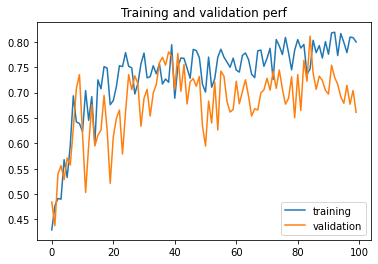

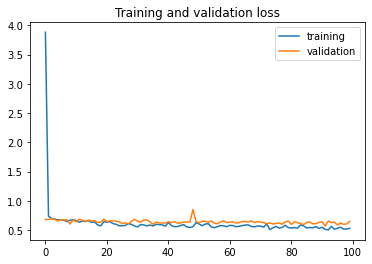

<Figure size 432x288 with 0 Axes>

In [24]:
plot_training_curve(history=history, training=("auc_2", "loss"), validation=("val_auc_2", "val_loss"))

In [21]:
# As we can see, the overfitting issue is solved but the 
# performance is still fluctuating like crazy. This is due
# to the small size of our training set. And even with some
# tricks like image augmentation and dropdout, our model
# ended up learning common features.

# Let use an existing model that's trained on far more data 
# and use the that that model learnt and apply them to our data:
# this is transfer learning.

# III. Transfer learning

In [22]:
# To do transfer learning, one crucial question is:
# which model to use as base model ?

# Here I'll use efficientNet as it's perfomance matches SOTA models
# while requiring about 10x fewer parameters.

# There are quite a few flavors of the EfficientNet models 
# (EfficientNetB0, EfficientNetB1, …… EfficientB7) and they 
# differ slightly in architecture (i.e. network depth, width) 
# and resource limitations. Each of these models expects images 
# in a particular resolutions. Given we are working with 224x224 
# resolution images, we will go with EfficientNetB0.